In [6]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
import xgboost
import sklearn
import pylift
from annoy import AnnoyIndex
import random

In [7]:
# from google.cloud import bigquery


In [8]:
# client = bigquery.Client()

In [11]:
%%bash
gsutil cp results.csv gs://uplift-criteo/

Copying file://results.csv [Content-Type=text/csv]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1 files][  1.5 GiB/  1.5 GiB]   71.6 MiB/s                                   
Operation completed over 1 objects/1.5 GiB.                                      


In [2]:
data = pd.read_csv('train.csv')

/home/cbartondepaul/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,0.775465,3.26364,8.40525,3.02261,3.50673,10.1613,-0.728742,-0.166689,-18.1093,17.8461,-1.8609,4.15765,1,0,1,0
1,1.4787,3.41786,8.39088,2.34476,3.50673,10.8406,-2.38134,-0.760711,-10.0514,16.9877,-1.8609,4.15765,0,0,0,0
2,1.98739,3.26364,8.68354,2.94348,3.80315,10.1613,-0.668772,-0.166689,-10.8361,16.4826,-12.1264,4.15765,1,0,0,1
3,-1.40117,3.26364,9.2258,3.73587,3.50673,10.1613,-1.59224,-0.166689,-8.70447,9.85009,-1.8609,4.15765,1,0,0,0
4,0.552658,3.26364,8.70657,3.08626,3.50673,11.3226,-2.36213,-3.65345,-10.4621,13.1939,-1.8609,4.15765,1,0,0,0


In [4]:
test    = data[data.treatment == 1]
control = data[data.treatment == 0]

In [5]:
print(test.shape[0])
print(control.shape[0])

18562872
3385773


In [6]:
f = 12
t = AnnoyIndex(f)  # Length of item vector that will be indexed
for i in range(test.shape[0]):
    if i % 50000 == 0:
        clear_output()
        print(i/test.shape[0])
    ix = test.index[i]
    v = test.loc[ix][:-4]
    t.add_item(ix, v)

0.9993065728191198


In [7]:
t.build(10) # 10 trees

True

In [8]:
t.save('test_full.ann')

True

In [ ]:
# u = AnnoyIndex(f)
# u.load('test.ann') # super fast, will just mmap the file
# print(u.get_nns_by_item(0, 1000)) # will find the 1000 nearest neighbors

In [9]:
control.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
1,1.4787,3.41786,8.39088,2.34476,3.50673,10.8406,-2.38134,-0.760711,-10.0514,16.9877,-1.8609,4.15765,0,0,0,0
9,0.732334,3.26364,8.6784,2.70395,3.50673,10.1613,-1.30468,-0.166689,-8.28683,13.1939,-1.8609,4.15765,0,0,1,0
16,-0.742603,3.26364,8.98044,3.73587,3.50673,10.1613,-2.08654,-0.166689,-16.3117,9.85009,-1.8609,4.15765,0,0,0,0
33,0.947677,3.26364,8.44249,3.02261,4.01347,10.1613,-0.540946,-0.166689,-23.5006,24.4167,-8.74122,4.15765,0,0,0,0
38,1.52773,3.26364,8.55256,3.16273,3.50673,11.3226,-4.58455,-2.79102,-16.0807,16.5916,-1.8609,4.15765,0,0,1,0


In [25]:
matched_items = []
for row in range(control.shape[0]):
    d = t.get_nns_by_vector(control.iloc[row][:-4], 1, include_distances=True)
    control_ix      = control.index[row]
    test_ix         = d[0][0]
    dist            = d[1][0]
    test_outcome    = test.loc[test_ix][-3] 
    control_outcome = control.loc[control_ix][-3] 
    matched_items.append([control_ix, test_ix, control_outcome, test_outcome, dist])    
    if row % 50000 == 0:
        clear_output()
        print(row/control.shape[0])

0.9894343182487426


In [26]:
results = pd.DataFrame(matched_items)
results.columns = ['control_ix', 'test_ix', 'control_out', 'test_out', 'distance']

In [42]:
results.index = results.control_ix

In [44]:
results = pd.concat([results, control[control.columns[:-4]]], axis=1)

In [50]:
test_slide = test.loc[list(results.test_ix)][test.columns[:-4]]

In [53]:
test_slide.head()

,f0c,f1c,f2c,f3c,f4c,f5c,f6c,f7c,f8c,f9c,f10c,f11c
19114443,1.50353,3.41786,8.37205,2.30709,3.50673,10.8406,-2.52655,-0.75298,-9.90493,16.8941,-1.8609,4.15765
9637197,0.50616,3.26364,8.74993,2.61387,3.50673,10.1613,-1.34385,-0.166689,-8.28683,13.1939,-1.8609,4.15765
152609,-0.773452,3.26364,9.00574,3.73587,3.50673,10.1613,-2.03915,-0.166689,-16.247,9.85009,-1.8609,4.15765
81790,0.654126,3.26364,8.27405,2.878,3.80315,10.1613,-0.728742,-0.166689,-23.0661,24.185,-8.60127,4.15765
3238104,1.605,3.26364,8.38804,2.70395,3.50673,10.8406,-4.16901,-2.75129,-15.6146,16.2504,-1.8609,4.15765


In [52]:
test_slide.columns = ['f0c','f1c','f2c','f3c','f4c','f5c','f6c','f7c','f8c','f9c','f10c','f11c']

In [55]:
results.index = results.test_ix

In [57]:
results = pd.concat([results, test_slide], axis=1)

In [58]:
results.head()

,control_ix,test_ix,control_out,test_out,distance,f0,f1,f2,f3,f4,...,f2c,f3c,f4c,f5c,f6c,f7c,f8c,f9c,f10c,f11c
test_ix,,,,,,,,,,,,,,,,,,,,,
19114443,1,19114443,0,0,0.007983,1.4787,3.41786,8.39088,2.34476,3.50673,...,8.37205,2.30709,3.50673,10.8406,-2.52655,-0.75298,-9.90493,16.8941,-1.8609,4.15765
9637197,9,9637197,0,0,0.011760,0.732334,3.26364,8.6784,2.70395,3.50673,...,8.74993,2.61387,3.50673,10.1613,-1.34385,-0.166689,-8.28683,13.1939,-1.8609,4.15765
152609,16,152609,0,0,0.003313,-0.742603,3.26364,8.98044,3.73587,3.50673,...,9.00574,3.73587,3.50673,10.1613,-2.03915,-0.166689,-16.247,9.85009,-1.8609,4.15765
81790,33,81790,0,0,0.011970,0.947677,3.26364,8.44249,3.02261,4.01347,...,8.27405,2.878,3.80315,10.1613,-0.728742,-0.166689,-23.0661,24.185,-8.60127,4.15765
3238104,38,3238104,0,0,0.020262,1.52773,3.26364,8.55256,3.16273,3.50673,...,8.38804,2.70395,3.50673,10.8406,-4.16901,-2.75129,-15.6146,16.2504,-1.8609,4.15765


Matching Diagnostics 

Now that we have performed matching, we need to perform some diagnostics. There are several test we will perform.

1. Classifier to T-test to insure we cannot predict treatment variable based on sample.
    - We know this is the case with the entire dataset, however as we used a nearest neighbor apporach to find distances, we may have introduced bias. 
2. The C2T test should allow us to measure any bias in best versus control, the next test will help us to understand variance. For this we will take the mean of each 

1. take mean of each column in test/control. Do hypothesis test to see if they are different
2. 

In [12]:
results = pd.read_csv('results.csv')

In [13]:
results.head()

,control_ix,test_ix,control_out,test_out,distance,f0,f1,f2,f3,f4,...,f2c,f3c,f4c,f5c,f6c,f7c,f8c,f9c,f10c,f11c
0,1,19114443,0,0,0.007983,1.478699,3.417861,8.390882,2.344760,3.506733,...,8.372049,2.307094,3.506733,10.840586,-2.526549,-0.752980,-9.904933,16.894056,-1.860900,4.157648
1,9,9637197,0,0,0.011760,0.732334,3.263641,8.678399,2.703948,3.506733,...,8.749926,2.613870,3.506733,10.161281,-1.343855,-0.166689,-8.286829,13.193869,-1.860900,4.157648
2,16,152609,0,0,0.003313,-0.742603,3.263641,8.980436,3.735871,3.506733,...,9.005744,3.735871,3.506733,10.161281,-2.039146,-0.166689,-16.247004,9.850093,-1.860900,4.157648
3,33,81790,0,0,0.011970,0.947677,3.263641,8.442494,3.022606,4.013466,...,8.274047,2.877999,3.803153,10.161281,-0.728742,-0.166689,-23.066055,24.184974,-8.601271,4.157648
4,38,3238104,0,0,0.020262,1.527733,3.263641,8.552558,3.162731,3.506733,...,8.388038,2.703948,3.506733,10.840586,-4.169010,-2.751289,-15.614602,16.250365,-1.860900,4.157648


In [16]:
diff = np.array(results[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']]) - results[['f0c', 'f1c', 'f2c', 'f3c', 'f4c', 'f5c', 'f6c', 'f7c', 'f8c', 'f9c', 'f10c', 'f11c']]

#diff.boxplot(column=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11'])

/home/cbartondepaul/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  after removing the cwd from sys.path.


{'boxes': [<matplotlib.lines.Line2D at 0x7fa6b8c53240>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa6b8c5bba8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa6b8c61d30>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fa6b8c61518>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fa6b8c4bf28>,
  <matplotlib.lines.Line2D at 0x7fa6b8b3afd0>]}

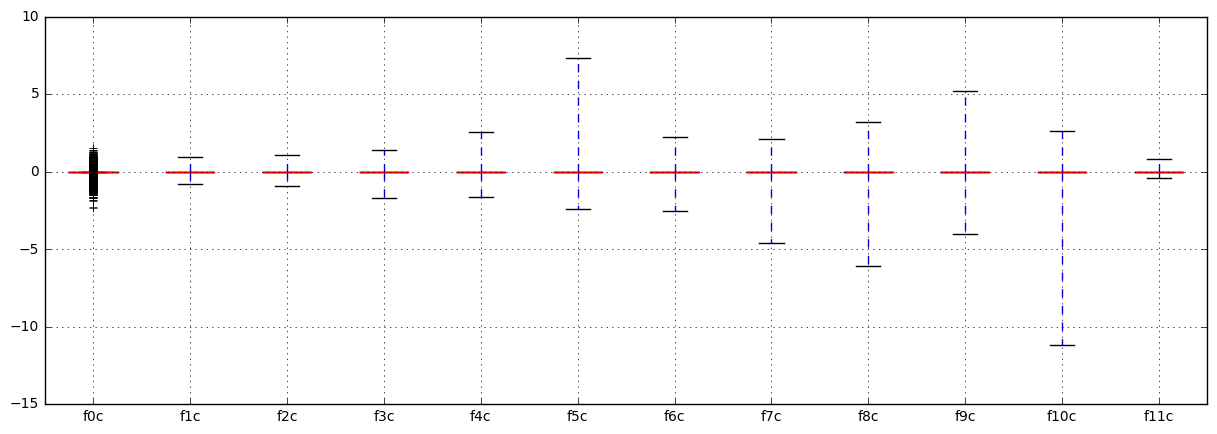

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams['figure.figsize'] = [15, 5]

diff = np.array(results[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']]) - results[['f0c', 'f1c', 'f2c', 'f3c', 'f4c', 'f5c', 'f6c', 'f7c', 'f8c', 'f9c', 'f10c', 'f11c']]

diff.boxplot(column=['f0c', 'f1c', 'f2c', 'f3c', 'f4c', 'f5c', 'f6c', 'f7c', 'f8c', 'f9c', 'f10c', 'f11c'])

In [21]:
# results['f11'] - results['f11c']

In [113]:
# results[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']].mean()

In [114]:
# results[['f0c', 'f1c', 'f2c', 'f3c', 'f4c', 'f5c', 'f6c', 'f7c', 'f8c', 'f9c', 'f10c', 'f11c']].mean()

In [25]:
from scipy.stats import ttest_ind

ttest_ind(results['f0'], results['f0c'])

Ttest_indResult(statistic=-5.7097452676234921, pvalue=1.1315010157426141e-08)

In [26]:
# low variance

In [27]:
# any bias. I assume there will be.

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import numpy as np
from sklearn.metrics import hamming_loss
from scipy import stats

In [48]:
clf=LogisticRegression()
loss=hamming_loss
bootstraps=300

c = results[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']]
c['treatment'] = 0

t = results[['f0c','f1c','f2c','f3c','f4c','f5c','f6c','f7c','f8c','f9c','f10c','f11c']]
t.columns = ['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']
t['treatment'] = 1
            
c2test = pd.concat([t, c])
c2test = c2test.sample(frac=0.1)

X_train, X_test, y_train, y_test = train_test_split(c2test[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']], c2test['treatment'], test_size=0.33, random_state=35)

y_pred = clf.fit(X_train, y_train).predict(X_test)
emp_loss = loss(y_test, y_pred)
bs_losses = []
y_bar = np.mean(c2test['treatment'])

for b in range(100+1):
    clear_output()
    print(b/100.)
    y_random = np.random.binomial(1, y_bar, size=c2test['treatment'].shape[0])
    X_train, X_test, y_train, y_test = train_test_split(c2test[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']], y_random)
    y_pred_bs = clf.fit(X_train, y_train).predict(X_test)
    bs_losses += [loss(y_test, y_pred_bs)]
    
pc = stats.percentileofscore(sorted(bs_losses), emp_loss) / 100.
pvalue = pc if pc < y_bar else 1 - pc

1.0


In [49]:
print("Loss of classifier trained on treatment variable of full dataset: %s" % emp_loss)
print("Average loss of classifers trained on random treatment variable: %s" % (np.mean(bs_losses)))

Loss of classifier trained on treatment variable of full dataset: 0.500058175439
Average loss of classifers trained on random treatment variable: 0.500085476889


In [50]:
stats.ttest_1samp(bs_losses, emp_loss)


Ttest_1sampResult(statistic=0.20887189235053805, pvalue=0.83497312540608026)

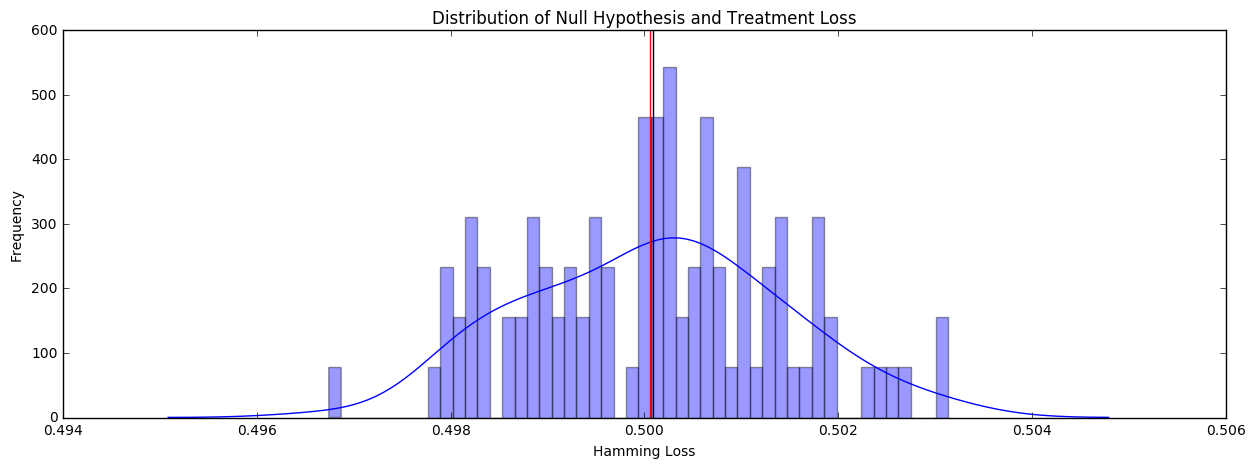

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(bs_losses, bins=50)
plt.axvline(emp_loss, color='r')
# plt.text(emp_loss+.1,0,'Treatment loss',rotation=90)
plt.axvline(np.mean(bs_losses), color='black')
plt.title("Distribution of Null Hypothesis and Treatment Loss")
plt.ylabel("Frequency")
plt.xlabel("Hamming Loss")

In [112]:
# pd.DataFrame(results['test_ix'].value_counts()[:100])

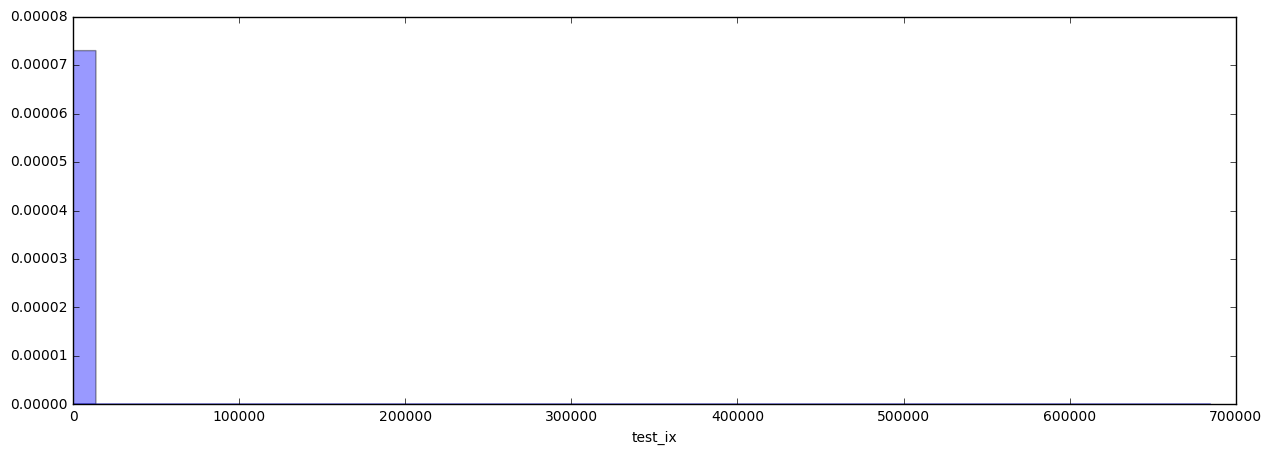

In [64]:
sns.distplot(results['test_ix'].value_counts())

In [96]:
br = pd.DataFrame(results['test_ix'].value_counts()[:100]).reset_index()

In [97]:
br.head()

,index,test_ix
0,1280898,684628
1,13550094,104536
2,16709608,2541
3,16967772,2443
4,7386755,2395


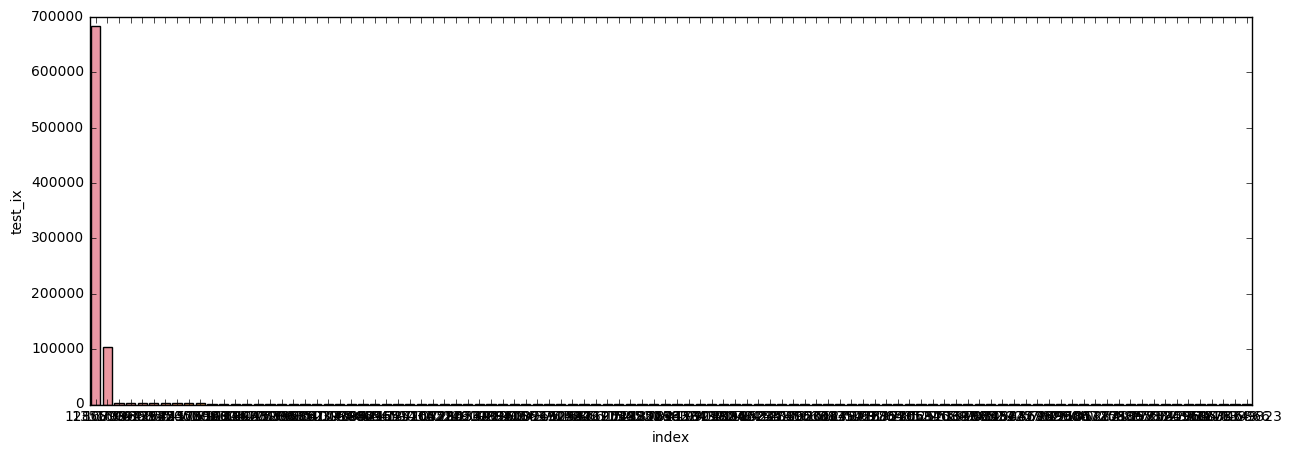

In [98]:
#sns.barplot(results['test_ix'].value_counts()[:100])
sns.barplot(x="index", y="test_ix", data=br, order=br['index'])

In [100]:
br = pd.DataFrame(results['test_ix'].value_counts()).reset_index()

In [104]:
br[br.test_ix ==1].shape[0] / br.shape[0]

0.7806243864229088

In [110]:
br = pd.DataFrame(results['test_ix'].value_counts()).reset_index()
results.index = results['test_ix']
sampled_results = results.loc[list(br[br.test_ix ==1]['index'])]

In [111]:
sampled_results.head()

,control_ix,test_ix,control_out,test_out,distance,f0,f1,f2,f3,f4,...,f2c,f3c,f4c,f5c,f6c,f7c,f8c,f9c,f10c,f11c
test_ix,,,,,,,,,,,,,,,,,,,,,
3016344,3016472,3016344,0,0,0.000000,-1.688018,3.263641,9.303380,3.735871,3.506733,...,9.305228,3.735871,3.506733,10.161281,2.386066,-0.166689,-0.584392,9.850093,-1.860900,4.157648
19242593,19213039,19242593,0,0,0.000074,1.991981,3.263641,8.625908,3.735871,3.506733,...,8.621006,3.735871,3.506733,10.161281,2.981721,-0.166689,-8.061212,14.400272,-1.860900,4.157648
3654030,9981133,3654030,0,0,0.009882,-0.152212,3.263641,9.309209,2.788978,3.506733,...,9.215848,2.858453,3.506733,10.161281,-3.069418,-0.166689,-4.677287,9.850093,-1.860900,4.157648
2611106,5773222,2611106,0,0,0.003311,-1.242291,3.263641,9.168223,3.735871,3.506733,...,9.191633,3.735871,3.506733,10.840586,0.477333,-3.966327,-2.716012,9.850093,-1.860900,4.157648
6708761,19275689,6708761,0,0,0.008894,1.991981,3.263641,8.391833,3.735871,3.803153,...,8.294610,3.735871,4.013466,10.161281,2.981721,-0.166689,-15.800094,18.219106,-3.205456,4.315296


/home/cbartondepaul/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  This is separate from the ipykernel package so we can avoid doing imports until


{'boxes': [<matplotlib.lines.Line2D at 0x7fa6a44df780>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa6a44ce2e8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa6a4532d68>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fa6a44bada0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fa6a44d9c88>,
  <matplotlib.lines.Line2D at 0x7fa69eb5ae48>]}

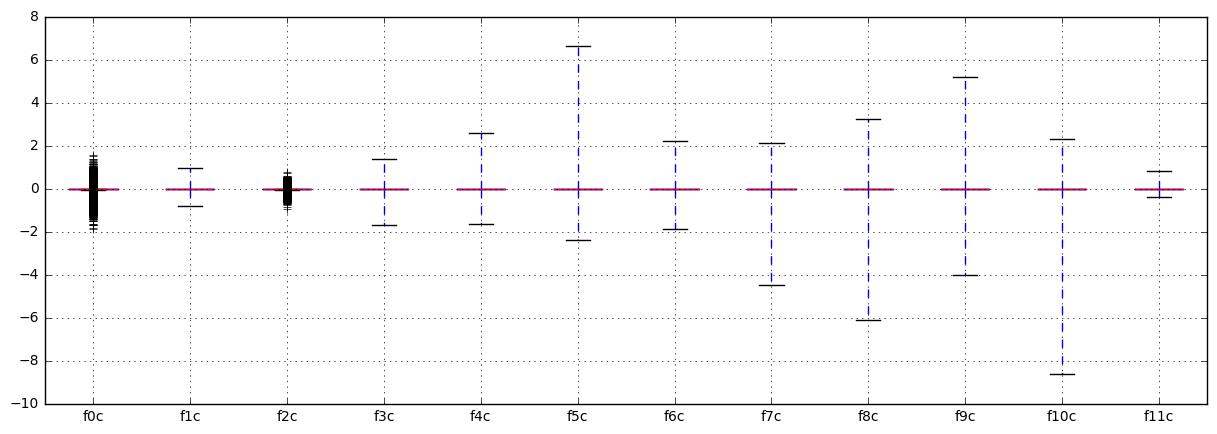

In [115]:
diff = np.array(sampled_results[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']]) - sampled_results[['f0c', 'f1c', 'f2c', 'f3c', 'f4c', 'f5c', 'f6c', 'f7c', 'f8c', 'f9c', 'f10c', 'f11c']]

diff.boxplot(column=['f0c', 'f1c', 'f2c', 'f3c', 'f4c', 'f5c', 'f6c', 'f7c', 'f8c', 'f9c', 'f10c', 'f11c'])

In [116]:
clf=LogisticRegression()
loss=hamming_loss
bootstraps=300

c = sampled_results[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']]
c['treatment'] = 0

t = sampled_results[['f0c','f1c','f2c','f3c','f4c','f5c','f6c','f7c','f8c','f9c','f10c','f11c']]
t.columns = ['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']
t['treatment'] = 1
            
c2test = pd.concat([t, c])
c2test = c2test.sample(frac=0.1)

X_train, X_test, y_train, y_test = train_test_split(c2test[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']], c2test['treatment'], test_size=0.33, random_state=35)

y_pred = clf.fit(X_train, y_train).predict(X_test)
emp_loss = loss(y_test, y_pred)
bs_losses = []
y_bar = np.mean(c2test['treatment'])

for b in range(100+1):
    clear_output()
    print(b/100.)
    y_random = np.random.binomial(1, y_bar, size=c2test['treatment'].shape[0])
    X_train, X_test, y_train, y_test = train_test_split(c2test[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']], y_random)
    y_pred_bs = clf.fit(X_train, y_train).predict(X_test)
    bs_losses += [loss(y_test, y_pred_bs)]
    
pc = stats.percentileofscore(sorted(bs_losses), emp_loss) / 100.
pvalue = pc if pc < y_bar else 1 - pc

print("Loss of classifier trained on treatment variable of full dataset: %s" % emp_loss)
print("Average loss of classifers trained on random treatment variable: %s" % (np.mean(bs_losses)))

1.0
Loss of classifier trained on treatment variable of full dataset: 0.497482883609
Average loss of classifers trained on random treatment variable: 0.498519144535


In [117]:
stats.ttest_1samp(bs_losses, emp_loss)

Ttest_1sampResult(statistic=3.7854163168078858, pvalue=0.00026184969691037075)

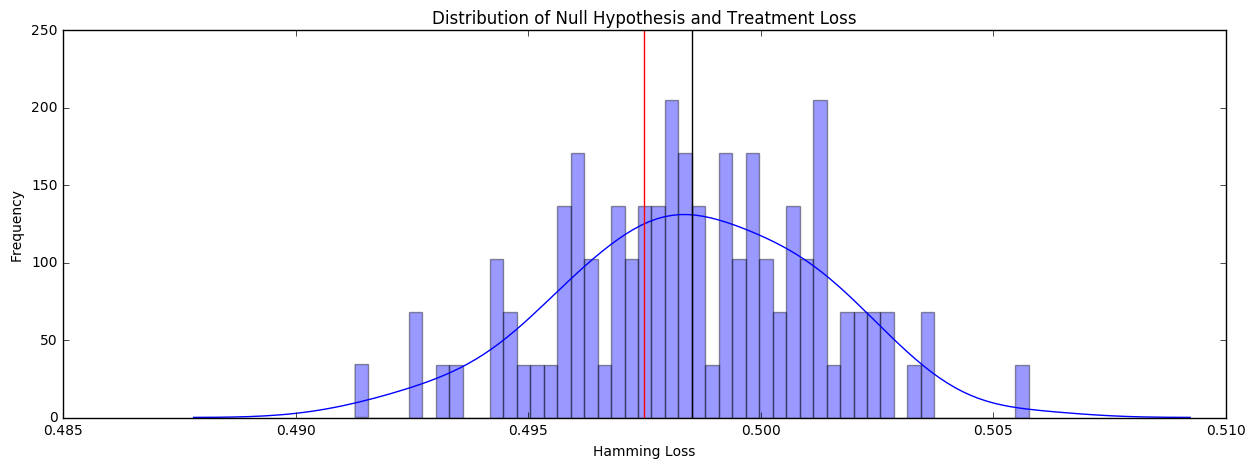

In [118]:
sns.distplot(bs_losses, bins=50)
plt.axvline(emp_loss, color='r')
# plt.text(emp_loss+.1,0,'Treatment loss',rotation=90)
plt.axvline(np.mean(bs_losses), color='black')
plt.title("Distribution of Null Hypothesis and Treatment Loss")
plt.ylabel("Frequency")
plt.xlabel("Hamming Loss")

In [ ]:
# product a number of files
# 1: just based on matched files (results.csv)
# 2. balanced to eliminate overrepresentation (sampled_results.csv)
# 3. exact match (exact)
# 4. exact plus single instance 


In [122]:
results[results.distance == 0].shape[0] / results.shape[0]

0.7841036596369574

In [123]:
results.head()

,control_ix,test_ix,control_out,test_out,distance,f0,f1,f2,f3,f4,...,f2c,f3c,f4c,f5c,f6c,f7c,f8c,f9c,f10c,f11c
test_ix,,,,,,,,,,,,,,,,,,,,,
19114443,1,19114443,0,0,0.007983,1.478699,3.417861,8.390882,2.344760,3.506733,...,8.372049,2.307094,3.506733,10.840586,-2.526549,-0.752980,-9.904933,16.894056,-1.860900,4.157648
9637197,9,9637197,0,0,0.011760,0.732334,3.263641,8.678399,2.703948,3.506733,...,8.749926,2.613870,3.506733,10.161281,-1.343855,-0.166689,-8.286829,13.193869,-1.860900,4.157648
152609,16,152609,0,0,0.003313,-0.742603,3.263641,8.980436,3.735871,3.506733,...,9.005744,3.735871,3.506733,10.161281,-2.039146,-0.166689,-16.247004,9.850093,-1.860900,4.157648
81790,33,81790,0,0,0.011970,0.947677,3.263641,8.442494,3.022606,4.013466,...,8.274047,2.877999,3.803153,10.161281,-0.728742,-0.166689,-23.066055,24.184974,-8.601271,4.157648
3238104,38,3238104,0,0,0.020262,1.527733,3.263641,8.552558,3.162731,3.506733,...,8.388038,2.703948,3.506733,10.840586,-4.169010,-2.751289,-15.614602,16.250365,-1.860900,4.157648


In [125]:
br = pd.DataFrame(results[results.distance == 0 ]['test_ix'].value_counts()).reset_index()
results.index = results['test_ix']
sampled_exact_results = results.loc[list(br[br.test_ix ==1]['index'])]

In [126]:
sampled_exact_results.head()

,control_ix,test_ix,control_out,test_out,distance,f0,f1,f2,f3,f4,...,f2c,f3c,f4c,f5c,f6c,f7c,f8c,f9c,f10c,f11c
test_ix,,,,,,,,,,,,,,,,,,,,,
12978749,3408352,12978749,0,0,0.0,1.991981,3.263641,8.981211,3.735871,3.506733,...,8.983805,3.735871,3.506733,10.161281,2.981721,-0.166689,-13.482981,9.850093,-1.8609,4.157648
10252550,16581748,10252550,0,0,0.0,-1.246184,3.263641,8.272483,3.735871,3.506733,...,8.272483,3.735871,3.506733,10.840586,0.477333,-3.913714,1.107571,9.850093,-1.8609,4.157648
3847594,6878330,3847594,0,0,0.0,-1.870487,3.263641,8.272483,3.735871,3.506733,...,8.272483,3.735871,3.506733,10.161281,-1.592239,-0.166689,1.107571,9.850093,-1.8609,4.157648
14728945,11544909,14728945,0,0,0.0,-0.621896,3.263641,8.272483,3.735871,3.506733,...,8.272483,3.735871,3.506733,10.161281,0.231920,-0.166689,1.107571,9.850093,-1.8609,4.157648
620405,16455881,620405,0,0,0.0,-1.084616,3.263641,8.272483,3.735871,3.506733,...,8.272483,3.735871,3.506733,10.161281,-1.136601,-0.166689,1.107571,9.850093,-1.8609,4.157648


In [127]:
results[results.distance == 0].to_csv('exact.csv', index=False)
sampled_exact_results.to_csv('sample_exact.csv', index=False)
sampled_results.to_csv('sample_results.csv', index=False)

In [124]:
# diff.hist(bins=100)

In [60]:
results.to_csv('results.csv', index=False)

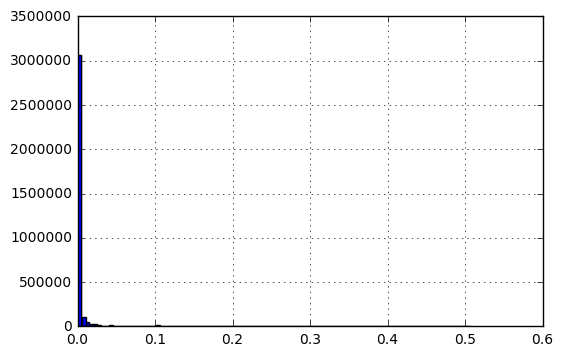

In [71]:
results.distance.hist(bins=100)

In [ ]:
# save covariates for each test and control

In [ ]:
# take difference 
# average difference for bias / variance diagnostics

In [ ]:
# find ways to pull data that produce different diagnostics 
# use best 